In [1]:
from pathlib import Path
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.PDB import MMCIFParser, PDBParser
from matplotlib.colors import LinearSegmentedColormap
import networkx as nx
from tqdm.notebook import tqdm
from tqdm import tqdm
from scipy.spatial import cKDTree

In [2]:
scoresAF2 = json.loads(Path("/Users/kamdiehl/Desktop/MOR1 Alphafold/MOR1 TOG1 Alphafold2/mor1tog1WTrank3best.json").read_text())
scoresAF3l6rem = json.loads(Path("/Users/kamdiehl/Desktop/MOR1 Alphafold/MOR1 TOG1 last 6 and first 1 rem/fold_mor1_tog1_last_6_rem_and_first_1_full_data_0.json").read_text())
scoresmor11 = json.loads(Path("/Users/kamdiehl/Desktop/MOR1 Alphafold/mor1-1 TOG1 last 6 and first 1 rem/fold_mor1_1_tog1_last_6_rem_and_first_1_full_data_0.json").read_text())
scoresMOR1tubulin = json.loads(Path("/Users/kamdiehl/Desktop/MOR1 Alphafold/TUA4 TUB4 MOR1/fold_tua4_tub4_mor1_full_data_0.json").read_text())
scoresmor11tubulin = json.loads(Path("/Users/kamdiehl/Desktop/MOR1 Alphafold/TUA4 TUB4 mor1-1/fold_tua4_tub4_mor1_1_full_data_0.json").read_text())

Finding interactions: 100%|██████████| 52185/52185 [00:00<00:00, 2543132.14it/s]


Found interaction: ('A', 109) <-> ('C', 181) at distance 3.76 Å
Found interaction: ('A', 409) <-> ('C', 181) at distance 3.14 Å
Found interaction: ('A', 410) <-> ('C', 181) at distance 3.12 Å
Found interaction: ('A', 412) <-> ('C', 214) at distance 2.57 Å
Found interaction: ('A', 414) <-> ('C', 186) at distance 2.82 Å
Found interaction: ('A', 417) <-> ('C', 214) at distance 3.50 Å
Found interaction: ('A', 112) <-> ('C', 179) at distance 3.76 Å
Found interaction: ('A', 409) <-> ('C', 186) at distance 3.26 Å
Found interaction: ('A', 413) <-> ('C', 186) at distance 3.36 Å
Found interaction: ('A', 412) <-> ('C', 181) at distance 3.52 Å
Find residues complete
Strong H bonds (<= 3.0 Å): 2
Weak H bonds (> 3.0 Å): 8


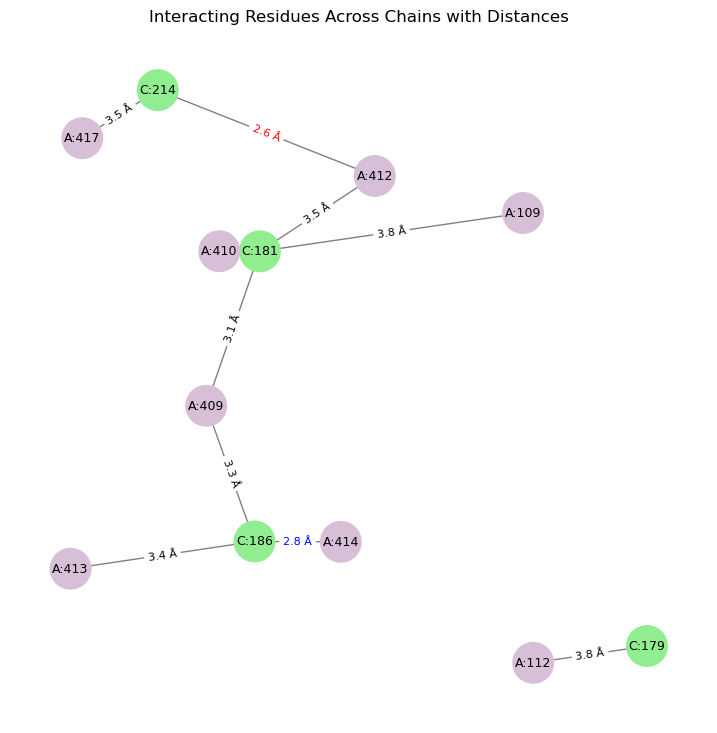


Detailed Interaction Data:
Interaction between A:109 (OG1 - O) and C:181 (NE2 - N):
  Distance: 3.76 Å
  Score: 0.035
  H-bond type: weak
  On graph: True
------------------------------------------------------------
Interaction between A:409 (O - O) and C:181 (O - O):
  Distance: 3.14 Å
  Score: 0.071
  H-bond type: normal
  On graph: True
------------------------------------------------------------
Interaction between A:410 (O - O) and C:181 (O - O):
  Distance: 3.12 Å
  Score: 0.072
  H-bond type: normal
  On graph: True
------------------------------------------------------------
Interaction between A:412 (O - O) and C:214 (NH1 - N):
  Distance: 2.57 Å
  Score: 0.076
  H-bond type: strong
  On graph: True
------------------------------------------------------------
Interaction between A:414 (OE1 - O) and C:186 (NH2 - N):
  Distance: 3.28 Å
  Score: 0.046
  H-bond type: normal
  On graph: True
------------------------------------------------------------
Interaction between A:417 (OE

In [24]:
def extract_3d_coordinates(cif_file):
    """
    Extracts 3D coordinates (x, y, z) of atoms and their associated chain and residue IDs from a .cif file.
    
    Parameters:
    - cif_file (str): Path to the .cif file.
    
    Returns:
    - atom_data (list): List of dictionaries containing atom coordinates and identifiers.
    - coord_array (numpy.ndarray): Array of atom coordinates for KD-tree.
    """
    parser = MMCIFParser(QUIET=True)
    structure = parser.get_structure("protein", cif_file)
    
    atom_data = []
    coord_list = []
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    atom_data.append({
                        "chain_id": chain.id,
                        "residue_id": residue.id[1],
                        "atom_name": atom.name,
                        "position": atom.coord,
                        "element": atom.element
                    })
                    coord_list.append(atom.coord)
    
    return atom_data, np.array(coord_list)




def is_hydrogen_bond_possible(atom1, atom2):
    """
    Check if two atoms are capable of forming a hydrogen bond.
    Criteria:
    1. Must have potential donor and acceptor atoms
    2. Distance between atoms must be reasonable
    3. Angle between donor-hydrogen-acceptor must be physically plausible (>120°)
    """
    donors = set(['N', 'O'])  # Common hydrogen bond donors
    acceptors = set(['N', 'O', 'S'])  # Common hydrogen bond acceptors

    if atom1["element"] in donors and atom2["element"] in acceptors:
        donor_atom, acceptor_atom = atom1, atom2
    elif atom2["element"] in donors and atom1["element"] in acceptors:
        donor_atom, acceptor_atom = atom2, atom1
    else:
        return False, "invalid"

    # Check distance
    distance = np.linalg.norm(donor_atom["position"] - acceptor_atom["position"])
    if distance > 4.0 or distance < 1.0:  # Typical hydrogen bond distance range
        return False, "weak"

    return True, "valid"






def calculate_interaction_score(atom1, atom2, distance):
    """
    Calculate a weighted interaction score based on atom types and distance.
    
    Returns:
    - Base score 
    - H-bond type (strong, normal, or weak)
    """
    # Check if H-bond is possible first
    h_bond_possible, h_bond_type = is_hydrogen_bond_possible(atom1, atom2)
    
    if not h_bond_possible:
        return 0.0, 'weak'

    """
    Calculate the hydrogen bond score based on the inverse square of the distance.
    
    Parameters:
    - distance (float): The distance between donor and acceptor atoms.
    
    Returns:
    - base_score (float): Calculated score inversely proportional to distance^2.
    - h_bond_type (str): Classification of the bond strength ('strong', 'normal', 'weak').
    """
    if distance <= 2.8:  # Very strong H-bond distance
        h_bond_type = 'strong'
    elif distance <= 3.3:  # Normal H-bond distance
        h_bond_type = 'normal'
    elif distance <= 4.0:  # Weak H-bond distance
        h_bond_type = 'weak'
    else:  # Outside typical H-bond range
        h_bond_type = 'weak'

    # Calculate base score inversely proportional to distance^2
    if distance > 0:  # Avoid division by zero
        base_score = 1 / (distance ** 2)
    else:
        base_score = 0.0 ###


    # Atom-specific weighting https://chem.libretexts.org/Courses/University_of_Missouri/MU%3A__1330H_(Keller)/08._Basic_Concepts_of_Chemical_Bonding/8.8%3A_Strength_of_Covalent_Bonds
    atom_pair_weights = {
        ('N', 'O'): 1.0,  # Strongest interactions #201
        ('O', 'O'): 0.7, #142
        ('N', 'N'): 0.8, # 167
        ('N', 'S'): 0.7,  # Weaker interactions
        ('O', 'S'): 0.6
    }

    atom_score = atom_pair_weights.get((atom1['element'], atom2['element']), 0.5)
    #atom_score = 1###
    # Final score calculation
    final_score = base_score * atom_score


    
    return final_score, h_bond_type








def find_interacting_residues(atom_data, coord_array, cutoff=4.0, include_chains=None, min_score=0.001):
    """
    Identifies interacting residues between specified chains based on a distance cutoff using KD-tree.
    
    Parameters:
    - atom_data (list): List of dictionaries containing atom coordinates and identifiers.
    - coord_array (numpy.ndarray): Array of atom coordinates.
    - cutoff (float): Distance cutoff for interaction in Ångstroms.
    - include_chains (list of tuples): List of chain pairs to include in the analysis.
    
    Returns:
    - interactions (list): List of tuples representing interactions and distances.
    """
    # Create KD-tree for efficient spatial searching
    tree = cKDTree(coord_array)
    
    interactions = []
    closest_distances = {}  # Track closest distances for each residue pair
    strong_h_bonds = 0
    weak_h_bonds = 0
    detailed_data = []

    # Perform efficient spatial search using KD-tree
    pairs = tree.query_pairs(r=cutoff)
    
    for (i, j) in tqdm(pairs, desc="Finding interactions"):
        atom1 = atom_data[i]
        atom2 = atom_data[j]
        
        # Skip atoms in the same chain
        if atom1["chain_id"] == atom2["chain_id"]:
            continue
        
        # Filter by specified chains if provided
        chain_pair = (atom1["chain_id"], atom2["chain_id"])
        if include_chains and chain_pair not in include_chains and chain_pair[::-1] not in include_chains:
            continue
        
        # Compute distance
        dist = np.linalg.norm(atom1["position"] - atom2["position"])
        score, h_bond_type = calculate_interaction_score(atom1, atom2, dist) #!!!!!!!!!!!!!!!!!!!!!!!
        
        if score < min_score:
            continue
            
        # Prepare residue pair for tracking
        residue_pair = tuple(sorted([(atom1["chain_id"], atom1["residue_id"]), 
                                     (atom2["chain_id"], atom2["residue_id"])]))
        
        # Update closest distance for residue pair
        if residue_pair not in closest_distances or dist < closest_distances[residue_pair]:
            closest_distances[residue_pair] = dist

    
        detailed_data.append({
            "atom1": atom1,
            "atom2": atom2,
            "distance": dist,
            "score": score,
            "h_bond_type": h_bond_type,
            "chain1": atom1["chain_id"],
            "residue1": atom1["residue_id"],
            "chain2": atom2["chain_id"],
            "residue2": atom2["residue_id"],
            "on_graph": residue_pair in closest_distances and closest_distances[residue_pair] == dist  # Check if the bond is on the graph
        })


    
    # Process the closest distances
    for residue_pair, dist in closest_distances.items():
        interactions.append((residue_pair[0], residue_pair[1], dist))
        if dist <= 3.0:
            strong_h_bonds += 1
        else:
            weak_h_bonds += 1
        print(f"Found interaction: {residue_pair[0]} <-> {residue_pair[1]} at distance {dist:.2f} Å")

    print("Find residues complete")
    print(f"Strong H bonds (<= 3.0 Å): {strong_h_bonds}")
    print(f"Weak H bonds (> 3.0 Å): {weak_h_bonds}")
    return interactions, detailed_data

def visualize_interactions(interactions, detailed_data, minimum_score=0.03, save_path=None):
    """
    Visualizes interactions between residues using a network graph.
    
    Parameters:
    - interactions (list): List of tuples representing interactions.
    - save_path (str): Optional path to save the figure.
    """
    G = nx.Graph()
    
    for interaction in interactions:
        (chain1, res1), (chain2, res2), distance = interaction
        node1 = f"{chain1}:{res1}"
        node2 = f"{chain2}:{res2}"
        G.add_node(node1, chain=chain1)
        G.add_node(node2, chain=chain2)
        G.add_edge(node1, node2, weight=distance)
    
    chain_colors = {'A': 'thistle', 'B': 'lightcoral', 'C': 'lightgreen'}
    node_colors = [chain_colors[G.nodes[node]['chain']] for node in G.nodes]

    # Adjust layout based on number of connections
    def custom_k(node):
        if len(list(G.edges(node))) >= 2:
            return 2.3  # Higher repulsion for highly connected nodes
        else:
            return 1.5  # Standard repulsion for others

    k_values = {node: custom_k(node) for node in G.nodes}
    pos = nx.spring_layout(G, k=1.5, iterations=100, seed=42)  # Base layout
    for node, k in k_values.items():
        pos[node] = nx.spring_layout(G, k=k, iterations=100, seed=42)[node]

    plt.figure(figsize=(9, 9))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=850)
    nx.draw_networkx_edges(G, pos, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=9)
    
    # Add edge labels with distances
    edge_labels = {(u, v): f"{d['weight']:.1f} Å" for u, v, d in G.edges(data=True)}
    
    # Adjust label colors based on distance
    label_colors = {key: 'black' if float(value.split()[0]) > 3.0 else 'blue' if float(value.split()[0]) > 2.6 else 'red' for key, value in edge_labels.items()}
    for edge, label in edge_labels.items():
        nx.draw_networkx_edge_labels(
            G, pos, edge_labels={edge: label}, font_size=8, font_color=label_colors[edge]
        )
    
    plt.title("Interacting Residues Across Chains with Distances")
    plt.axis('off')

    # Save or display the figure
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()
    print("\nDetailed Interaction Data:")
    print("=" * 60)
    for data in detailed_data:
        if data['score'] > minimum_score:
            print(f"Interaction between {data['chain1']}:{data['residue1']} "
                  f"({data['atom1']['atom_name']} - {data['atom1']['element']}) and "
                  f"{data['chain2']}:{data['residue2']} "
                  f"({data['atom2']['atom_name']} - {data['atom2']['element']}):")
            print(f"  Distance: {data['distance']:.2f} Å")
            print(f"  Score: {data['score']:.3f}")
            print(f"  H-bond type: {data['h_bond_type']}")
            print(f"  On graph: {data['on_graph']}")
            print("-" * 60)






# USE IT
def main():
    global_min_score = 0.03
    include_chainz = [('A','C')]
    cif_file_path = "/Users/kamdiehl/Desktop/MOR1 Alphafold/TUA4 TUB4 mor1-1/fold_tua4_tub4_mor1_1_model_0.cif"
    
    atom_data, coord_array = extract_3d_coordinates(cif_file_path)

    interactions, detailed_data = find_interacting_residues(
        atom_data, 
        coord_array, 
        cutoff=4.0, 
        include_chains=include_chainz,
        min_score=global_min_score
    )

    visualize_interactions(
        interactions, 
        detailed_data,
        minimum_score=global_min_score,
        save_path="/Users/kamdiehl/Desktop/MOR1 Alphafold/Manuscript Figures/MOR1 B and C interacting.png"
    )

if __name__ == "__main__":
    main()

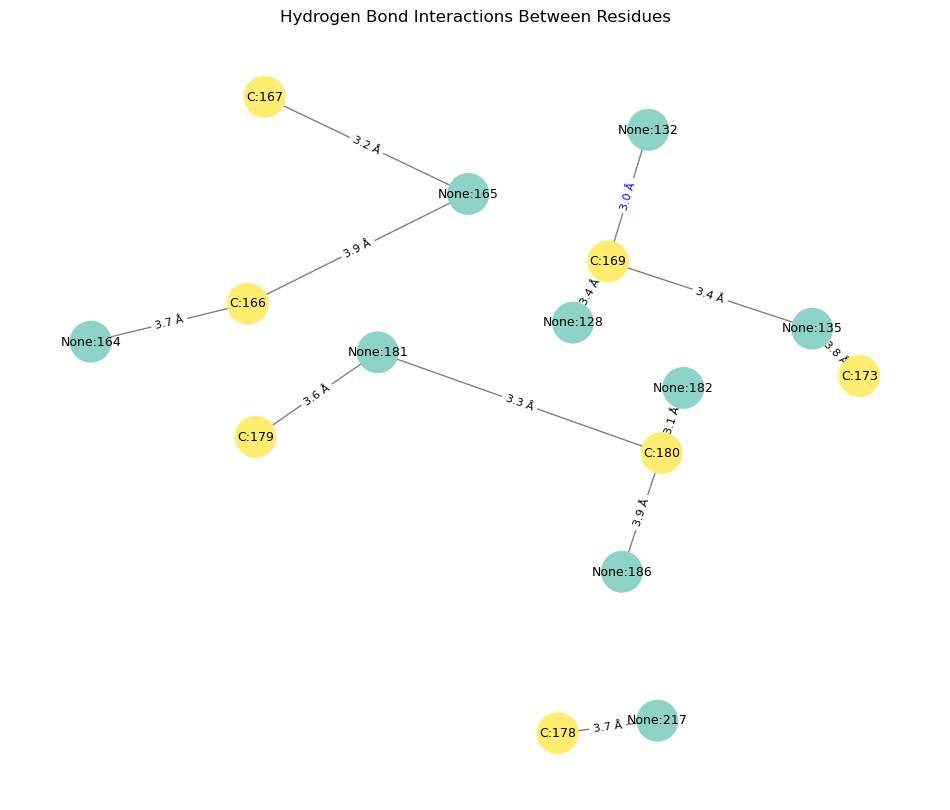


Detailed Interaction Data:
Interaction between C:166 (N - N) and C:165 (O - O):
  Distance: 2.25 Å
  Score: 0.197
  H-bond type: strong
------------------------------------------------------------
Interaction between C:166 (N - N) and C:165 (N - N):
  Distance: 3.36 Å
  Score: 0.071
  H-bond type: weak
------------------------------------------------------------
Interaction between C:166 (N - N) and C:164 (O - O):
  Distance: 3.72 Å
  Score: 0.072
  H-bond type: weak
------------------------------------------------------------
Interaction between C:166 (O - O) and C:165 (O - O):
  Distance: 3.91 Å
  Score: 0.046
  H-bond type: weak
------------------------------------------------------------
Interaction between C:167 (N - N) and C:165 (O - O):
  Distance: 3.21 Å
  Score: 0.097
  H-bond type: normal
------------------------------------------------------------
Interaction between C:169 (NH1 - N) and C:132 (OD1 - O):
  Distance: 2.66 Å
  Score: 0.142
  H-bond type: strong
---------------

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import cKDTree
from tqdm import tqdm
from Bio.PDB.MMCIFParser import MMCIFParser
import json

class ProteinHBondAnalyzer:
    def __init__(self, structure_file):
        """
        Initialize the analyzer with a protein structure file.
        Supports .cif and .json (AlphaFold) formats.
        
        Parameters:
        - structure_file (str): Path to the protein structure file
        """
        self.structure_file = structure_file
        self.atom_data = []
        self.coord_array = []
        self.chains = {}
        
        # Determine file type and parse accordingly
        if structure_file.endswith('.cif'):
            self._parse_cif_file()
        elif structure_file.endswith('.json'):
            self._parse_alphafold_json()
        else:
            raise ValueError("Unsupported file format. Use .cif or AlphaFold .json")
    
    def _parse_cif_file(self):
        """Parse a .cif file and extract atom coordinates and chain information"""
        parser = MMCIFParser(QUIET=True)
        structure = parser.get_structure("protein", self.structure_file)
        
        for model in structure:
            for chain in model:
                chain_atoms = []
                chain_coords = []
                residues = []
                
                for residue in chain:
                    residue_atoms = []
                    for atom in residue:
                        atom_info = {
                            "chain_id": chain.id,
                            "residue_id": residue.id[1],
                            "residue_name": residue.resname,
                            "atom_name": atom.name,
                            "position": atom.coord,
                            "element": atom.element
                        }
                        chain_atoms.append(atom_info)
                        chain_coords.append(atom.coord)
                        residue_atoms.append(atom_info)
                    
                    residues.append({
                        "residue_id": residue.id[1],
                        "residue_name": residue.resname,
                        "atoms": residue_atoms
                    })
                
                self.chains[chain.id] = {
                    "atoms": chain_atoms,
                    "coordinates": np.array(chain_coords),
                    "residues": residues
                }
        
        # Combine all atom data and coordinates for global analysis
        self.atom_data = [atom for chain in self.chains.values() for atom in chain['atoms']]
        self.coord_array = np.array([atom['position'] for atom in self.atom_data])
    
    def _parse_alphafold_json(self):
        """Parse an AlphaFold JSON file"""
        with open(self.structure_file, 'r') as f:
            data = json.load(f)
        
        # Implement JSON parsing logic here
        # This will depend on the exact structure of the AlphaFold JSON
        raise NotImplementedError("AlphaFold JSON parsing not yet implemented")
    
    def find_hydrogen_bonds(self, 
                             chain1, 
                             residue_range1=None, 
                             chain2=None, 
                             residue_range2=None, 
                             cutoff=4.0, 
                             min_score=0.001):
        """
        Find hydrogen bonds between specified residue ranges in specified chains.
        
        Parameters:
        - chain1 (str): First chain identifier
        - residue_range1 (tuple): Start and end residue IDs for first chain (optional)
        - chain2 (str): Second chain identifier (optional, for inter-chain bonds)
        - residue_range2 (tuple): Start and end residue IDs for second chain (optional)
        - cutoff (float): Maximum distance for hydrogen bond detection
        - min_score (float): Minimum interaction score threshold
        
        Returns:
        - interactions (list): List of hydrogen bond interactions
        - detailed_data (list): Detailed information about each interaction
        """
        # Filter atoms based on specified ranges
        def filter_atoms(chain_data, residue_range):
            if not residue_range:
                return chain_data['atoms']
            
            start, end = residue_range
            return [
                atom for atom in chain_data['atoms']
                if start <= atom['residue_id'] <= end
            ]
        
        chain1_atoms = filter_atoms(self.chains[chain1], residue_range1)
        
        # Determine which atoms to search against
        if chain2:
            chain2_atoms = filter_atoms(self.chains[chain2], residue_range2)
        else:
            # If no second chain, search within the same chain
            chain2_atoms = [
                atom for atom in self.chains[chain1]['atoms']
                if not (residue_range1 and residue_range1[0] <= atom['residue_id'] <= residue_range1[1])
            ]
        
        # Create coordinate arrays
        chain1_coords = np.array([atom['position'] for atom in chain1_atoms])
        chain2_coords = np.array([atom['position'] for atom in chain2_atoms])
        
        # Use scipy's distance matrix for efficient searching
        tree = cKDTree(chain2_coords)
        interactions = []
        detailed_data = []
        
        for i, atom1 in enumerate(chain1_atoms):
            # Find nearby atoms in the second set
            distances, indices = tree.query(atom1['position'], k=10, distance_upper_bound=cutoff)
            
            for dist, j in zip(distances, indices):
                if dist == np.inf:
                    break
                
                atom2 = chain2_atoms[j]
                
                # Skip same atom or atoms in same residue for intra-chain searches
                if atom1 == atom2 or (chain1 == chain2 and atom1['residue_id'] == atom2['residue_id']):
                    continue
                
                # Calculate interaction score
                score, h_bond_type = self._calculate_interaction_score(atom1, atom2, dist)
                
                if score >= min_score:
                    interactions.append((
                        (chain1, atom1['residue_id']), 
                        (chain2, atom2['residue_id']), 
                        dist
                    ))
                    
                    detailed_data.append({
                        "atom1": atom1,
                        "atom2": atom2,
                        "distance": dist,
                        "score": score,
                        "h_bond_type": h_bond_type
                    })
        
        return interactions, detailed_data
    
    def _calculate_interaction_score(self, atom1, atom2, distance):
        """
        Calculate hydrogen bond interaction score.
        
        Parameters:
        - atom1, atom2 (dict): Atom information
        - distance (float): Distance between atoms
        
        Returns:
        - score (float): Interaction score
        - h_bond_type (str): Type of hydrogen bond
        """
        donors = set(['N', 'O'])
        acceptors = set(['N', 'O', 'S'])

        if atom1["element"] in donors and atom2["element"] in acceptors:
            donor_atom, acceptor_atom = atom1, atom2
        elif atom2["element"] in donors and atom1["element"] in acceptors:
            donor_atom, acceptor_atom = atom2, atom1
        else:
            return 0.0, 'invalid'

        # Distance-based bond type
        if distance <= 2.8:
            h_bond_type = 'strong'
        elif distance <= 3.3:
            h_bond_type = 'normal'
        elif distance <= 4.0:
            h_bond_type = 'weak'
        else:
            return 0.0, 'weak'

        # Calculate base score inversely proportional to distance^2
        base_score = 1 / (distance ** 2) if distance > 0 else 0.0

        # Atom-specific weighting
        atom_pair_weights = {
            ('N', 'O'): 1.0,  # Strongest interactions
            ('O', 'O'): 0.7,
            ('N', 'N'): 0.8,
            ('N', 'S'): 0.7,  # Weaker interactions
            ('O', 'S'): 0.6
        }

        atom_score = atom_pair_weights.get((atom1['element'], atom2['element']), 0.5)
        final_score = base_score * atom_score

        return final_score, h_bond_type
    
    def visualize_interactions(self, interactions, detailed_data, minimum_score=0.03, save_path=None):
        """
        Visualize hydrogen bond interactions as a network graph.
        
        Parameters:
        - interactions (list): List of interactions
        - detailed_data (list): Detailed interaction data
        - minimum_score (float): Minimum score to display
        - save_path (str): Optional path to save the figure
        """
        G = nx.Graph()
        
        for interaction in interactions:
            (chain1, res1), (chain2, res2), distance = interaction
            node1 = f"{chain1}:{res1}"
            node2 = f"{chain2}:{res2}"
            G.add_node(node1, chain=chain1)
            G.add_node(node2, chain=chain2)
            G.add_edge(node1, node2, weight=distance)
        
        # Color chains distinctly
        unique_chains = list(set(nx.get_node_attributes(G, 'chain').values()))
        chain_colors = plt.cm.Set3(np.linspace(0, 1, len(unique_chains)))
        chain_color_map = {chain: color for chain, color in zip(unique_chains, chain_colors)}
        
        node_colors = [chain_color_map[G.nodes[node]['chain']] for node in G.nodes]

        # Custom layout to separate highly connected nodes
        def custom_k(node):
            return 2.3 if len(list(G.edges(node))) >= 2 else 1.5

        k_values = {node: custom_k(node) for node in G.nodes}
        pos = nx.spring_layout(G, k=1.5, iterations=100, seed=42)
        for node, k in k_values.items():
            pos[node] = nx.spring_layout(G, k=k, iterations=100, seed=42)[node]

        plt.figure(figsize=(12, 10))
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=850)
        nx.draw_networkx_edges(G, pos, edge_color='gray')
        nx.draw_networkx_labels(G, pos, font_size=9)
        
        # Color-coded edge labels
        edge_labels = {(u, v): f"{d['weight']:.1f} Å" for u, v, d in G.edges(data=True)}
        label_colors = {
            key: 'black' if float(value.split()[0]) > 3.0 
            else 'blue' if float(value.split()[0]) > 2.6 
            else 'red' 
            for key, value in edge_labels.items()
        }
        
        for edge, label in edge_labels.items():
            nx.draw_networkx_edge_labels(
                G, pos, edge_labels={edge: label}, 
                font_size=8, font_color=label_colors[edge]
            )
        
        plt.title("Hydrogen Bond Interactions Between Residues")
        plt.axis('off')

        if save_path:
            plt.savefig(save_path, dpi=300)
        plt.show()
        
        # Print detailed interaction data
        print("\nDetailed Interaction Data:")
        print("=" * 60)
        for data in detailed_data:
            if data['score'] > minimum_score:
                print(f"Interaction between {data['atom1']['chain_id']}:{data['atom1']['residue_id']} "
                      f"({data['atom1']['atom_name']} - {data['atom1']['element']}) and "
                      f"{data['atom2']['chain_id']}:{data['atom2']['residue_id']} "
                      f"({data['atom2']['atom_name']} - {data['atom2']['element']}):")
                print(f"  Distance: {data['distance']:.2f} Å")
                print(f"  Score: {data['score']:.3f}")
                print(f"  H-bond type: {data['h_bond_type']}")
                print("-" * 60)

def main():
    # Example usage
    cif_file_path = "/Users/kamdiehl/Desktop/MOR1 Alphafold/TUA4 TUB4 mor1-1/fold_tua4_tub4_mor1_1_model_0.cif"
    
    # Initialize the analyzer
    analyzer = ProteinHBondAnalyzer(cif_file_path)
    
    # Find hydrogen bonds between specific residue ranges and chains
    interactions, detailed_data = analyzer.find_hydrogen_bonds(
        chain1='C',           # First chain
        residue_range1=(166, 180),  # Residue range in first chain
        #chain2='',           # Second chain (optional)
        #residue_range2=(0, 0),  # Residue range in second chain (optional)
        cutoff=4,           # Maximum distance for H-bond
        min_score=0.02
        # Minimum interaction score
    )
    
    # Visualize interactions
    analyzer.visualize_interactions(
        interactions, 
        detailed_data, 
        minimum_score=0.0,
        save_path="/Users/kamdiehl/Desktop/MOR1 Alphafold/Manuscript Figures/MOR1.png"
    )

if __name__ == "__main__":
    main()